In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

Metal device set to: AMD Radeon Pro 560X

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



2023-12-27 23:17:20.506913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-27 23:17:20.507257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


['/device:GPU:0']

In [3]:
import pandas as pd
from prepare_data import load_images_and_annotations
from helpers import plot_image_with_boxes
import numpy as np
from model import define_and_compile_model
from interpret_results import non_max_suppression, get_outputs
import matplotlib.pyplot as plt

In [1]:
!curl -L "https://universe.roboflow.com/ds/ZdIkNMw7q1?key=4rUnbzhtLI" > data/roboflow.zip; unzip data/roboflow.zip; rm data/roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   890  100   890    0     0    110      0  0:00:08  0:00:08 --:--:--   208
100  178M  100  178M    0     0   545k      0  0:05:34  0:05:34 --:--:--  853k57  0:00:09  0:35:48  783k:55  0:00:24  0:05:31  686k0     0   538k      0  0:05:39  0:00:25  0:05:14  825k  0  0:05:23  0:00:27  0:04:56  891kk      0  0:05:32  0:00:59  0:04:33  580k   593k      0  0:05:08  0:01:06  0:04:02  978k0.4M    0     0   597k      0  0:05:05  0:01:09  0:03:56  825k0   632k      0  0:04:49  0:01:18  0:03:31 1068k0   627k      0  0:04:51  0:01:43  0:03:08  761k7k      0  0:04:51  0:01:45  0:03:06  718k    0  0:04:53  0:01:59  0:02:54  564kk      0  0:05:13  0:02:26  0:02:47  418k   543k      0  0:05:36  0:05:02  0:00:34  413k
Archive:  data/roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 ext

In [4]:
data = pd.read_csv("data/train/_annotations.csv")
data = data[data["filename"].isin(data['filename'].drop_duplicates()[:3500])]

In [5]:
input_size = (224, 224)
grid = (7, 7)
images, annotations, num2classes, classes2num, num_classes = load_images_and_annotations(data, input_size, grid)
# Print the shape of the loaded data
print('Images shape:', images.shape)
print('Annotations shape:', annotations.shape)

Images shape: (2633, 224, 224, 3)
Annotations shape: (2633, 7, 7, 17)


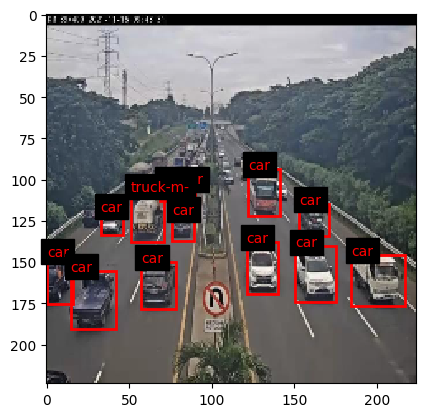

In [6]:
# Assuming you have already loaded the images and annotations
image_index = np.random.randint(0, images.shape[0])
image = images[image_index]
annotation = annotations[image_index]

# Plot the image with bounding boxes
plot_image_with_boxes(image, annotation, grid, num2classes)

In [7]:
model = define_and_compile_model(num_classes, grid)
model.summary()

2023-12-27 23:18:00.143999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-27 23:18:00.144031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
model.fit(x=images, y=annotations, epochs=50)

Epoch 1/50
83/83 [==============================] - 50s 603ms/step - loss: 1120.4110 - <lambda>: 0.7610
Epoch 2/50
83/83 [==============================] - 47s 570ms/step - loss: 1129.2648 - <lambda>: 0.7587
Epoch 3/50
83/83 [==============================] - 47s 570ms/step - loss: 1120.3502 - <lambda>: 0.7626
Epoch 4/50
83/83 [==============================] - 48s 576ms/step - loss: 1105.2269 - <lambda>: 0.7643
Epoch 5/50
83/83 [==============================] - 47s 566ms/step - loss: 1117.9708 - <lambda>: 0.7608
Epoch 6/50
83/83 [==============================] - 47s 565ms/step - loss: 1117.6177 - <lambda>: 0.7636
Epoch 7/50
83/83 [==============================] - 46s 557ms/step - loss: 1113.6639 - <lambda>: 0.7620
Epoch 8/50
83/83 [==============================] - 46s 553ms/step - loss: 1122.9286 - <lambda>: 0.7621
Epoch 9/50
83/83 [==============================] - 52s 628ms/step - loss: 1125.5187 - <lambda>: 0.7615
Epoch 10/50
83/83 [==============================] - 66s 799ms/s

1/1 [==============================] - 0s 101ms/step


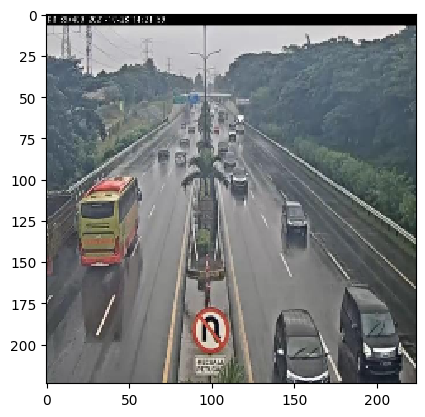

In [37]:
index = np.random.randint(0, images.shape[0])
random_image = images[index]
plt.imshow(random_image)
predicted_boxes = model.predict(random_image.reshape(1, 224, 224, 3))[0]

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bounding_boxes(image, boxes, pred_classes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, class_id in zip(boxes, pred_classes):
        x1, y1, x2, y2 = box

        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        predicted_class = num2classes[np.argmax(class_id)]
        # Add the class label text
        ax.text(x1, y1, f'{predicted_class}', color='r', fontsize=10, backgroundcolor='k')

    plt.show()


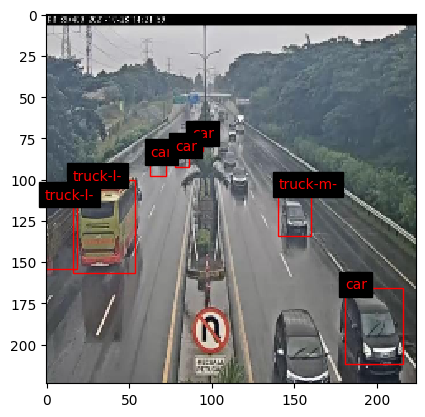

In [39]:
score_threshold = 0.5
iou_threshold = 0.5

boxes, scores, pred_classes = get_outputs(predicted_boxes, score_threshold)
selected_boxes, selected_scores, selected_classes = non_max_suppression(boxes, scores, pred_classes, score_threshold, iou_threshold)
plot_bounding_boxes(random_image, selected_boxes, selected_classes)